In [10]:
import requests
import pandas as pd
import numpy as np
import datetime
import copy

# are we using AEOLUS or FAERS_standard?
aeolus = 0
FAERS_std = 1


# rate limiting is important to avoid accidental service abuse of the OpenFDA API provider
from ratelimit import limits, sleep_and_retry

# cache API calls in a sqllite file to reduce the number of requests to openfda server
import requests_cache
requests_cache.install_cache('openfda_cache')

OPENFDA_API = "https://api.fda.gov/drug/event.json"

@sleep_and_retry
@limits(calls=40, period=60)
def call_api(params):
    """
    OpenFDA API call. Respects rate limit. Overrides default data limit
    Input: dictionary with API parameters {search: '...', count: '...'}
    Output: nested dictionary representation of the JSON results section
    
    OpenFDA API rate limits:
         With no API key: 40 requests per minute, per IP address. 1000 requests per day, per IP address.
         With an API key: 240 requests per minute, per key. 120000 requests per day, per key.
    """
    if not params:
        params = {}
    params['limit'] = params.get('limit', 1000)
    response = requests.get(OPENFDA_API, params=params)
    
    print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response.json()['results']

OPENFDA_METADATA_YAML = "https://open.fda.gov/fields/drugevent.yaml"
# munch is a yaml parser with javascript-style object access
from munch import Munch

def api_meta():
    """
    YAML file with field description and other metadata retrieved from the OpenFDA website
    Parses YAML file and provides syntactic sugar for accessing nested dictionaries
    Example: .patient.properties.patientagegroup.possible_values.value
    Note: reserved words, such as count and items still have to be accessed via ['count'], ['items']
    """
    response = requests.get(OPENFDA_METADATA_YAML)
    if response.status_code != 200:
        raise Exception('Could not retrieve YAML file with drug event API fields')
    y = Munch.fromYAML(response.text)
    return y['properties']

# API key that I got from FAERS site
columbia_api_key = 'Og4jAa0KIhPJkiwaxXVD6VHp3DGqoQf37JFPeRct'

In [11]:
start_date = '20110701'
end_date = '20110704'

#start_date = input("Enter the beginning of your desired date range (YYMMDDDD): " )
#end_date = input("Enter the end of your desired date range (YYMMDDDD): ")

#country_list = input("Enter the countries you would like to limit your search to: ")
country_list = ["BE", "FR", "DE", "NL", "GB", "PL", "ES", "CH"]

# reformat the dates to match FAERS
def get_dates(strt_dt, end_dt):
    # create a range of all dates between start and end date
    my_range = pd.date_range(start=strt_dt, end=end_dt)
    f_range = []
    for dt in my_range:
        y = str(dt)[0:4]
        m = str(dt)[5:7]
        d = str(dt)[8:10]
        new_dt = y + m + d
        f_range.append(new_dt)
    return f_range

start = '20190623'
end = '20190628'
date_range = get_dates(start, end)
print(date_range)

# list of dates to limit search to


['20190623', '20190624', '20190625', '20190626', '20190627', '20190628']


In [12]:
# strings that go in the URL of the API query


# test strings for API query search fields
date_query = 'patient.summary.narrativeincludeclinical:('
d_sub = '"CASE EVENT DATE:'

'''
# add each date in range to date_query
date_ind = 0
num_dates = len(date_range)
for ymd in date_range:
    date_ind += 1
    if date_ind < num_dates:
        date_query += d_sub + ymd + '"' + " OR "
    else:
        date_query += d_sub + ymd + '"' + ")"
'''


# potential search query terms to add to API query
#country_query = 'primarysource.reportercountry:"FR"'
#country_query = '(primarysource.reportercountry:"FR" OR occurcountry:"FR" OR primarysourcecountry:"FR")'
#country_query = 'primarysource.reportercountry:("FR" OR "DE" OR "ES" OR "IT" OR "CH")'
#country_query = 'occurcountry:("FR" OR "DE" OR "ES" OR "IT" OR "CH")'
#reaction_query = 'patient.reaction.reactionmeddrapt:("Heat exhaustion" OR "Heat stroke")'

# get an api response with the given search query terms
'''
test_out = call_api({
    'limit': 5,
    'api_key': columbia_api_key,
    'search': 'transmissiondate:[20040101 TO 20150630]' + ' AND ' + reaction_query
    #'search': 'transmissiondate:[20040101 TO 20150630]' + ' AND ' + country_query + ' AND ' + date_query
    #'search': 'transmissiondate:[20150630 TO 20150730]' + ' AND ' + country_query
    #'search': country_query + ' AND ' + date_query
    #'search': 'safetyreportid:10332098'

})
'''


"\ntest_out = call_api({\n    'limit': 5,\n    'api_key': columbia_api_key,\n    'search': 'transmissiondate:[20040101 TO 20150630]' + ' AND ' + reaction_query\n    #'search': 'transmissiondate:[20040101 TO 20150630]' + ' AND ' + country_query + ' AND ' + date_query\n    #'search': 'transmissiondate:[20150630 TO 20150730]' + ' AND ' + country_query\n    #'search': country_query + ' AND ' + date_query\n    #'search': 'safetyreportid:10332098'\n\n})\n"

In [13]:

# list to store all case IDs
safetyreportid_list = []

# iterate through each entry, store safetyreportid
def get_safetyreportids(api_results):
    write_obj = open('results.txt', 'w')
    write_obj.close()
    results_obj = open('results.txt', 'a')
    for entry in api_results:
        # safetyreportid
        results_obj.write("report ID: ")
        results_obj.write(str(entry['safetyreportid']) + "\n")
        safetyreportid_list.append(str(entry['safetyreportid']))

        # reportercountry
        results_obj.write("\treportercountry: " + str(entry['primarysource']['reportercountry']) + "\n")

        # sex
        if 'patientsex' in entry['patient']:
            results_obj.write("\tsex: " + str(entry['patient']['patientsex']) + "\n")

        # date
        if 'summary' in entry['patient']:
            results_obj.write("\t" + str(entry['patient']['summary']['narrativeincludeclinical']) + "\n")
    results_obj.close()

    
#get_safetyreportids(test_out)

In [14]:
# dictionary templates


# template for KEGG value
KEGG_template = {"get_URL": None, "D_number": None, "Classes": [], "Target": [ ], "Pathway": None }  

if aeolus == 1:
    # template for a drug value
    drug_template = { "drug_concept_id": None, "drug_name": None, "role_cod": None, "KEGG": KEGG_template.copy()}

    # template for a primaryid value
    pid_template = {'reactions_SNOMED': [], 'reactions_MedDRA': [], 'drugs': []}

if FAERS_std == 1:
    # template for a drug value
    drug_template = { "drug_concept_id": None, "drug_name": None, "role_cod": None, "KEGG": KEGG_template.copy()}

    # template for a primaryid value
    pid_template = { 'reactions_MedDRA': None, 'drugs': []}


In [15]:

# get lines in given file that match certain strings
# used to search standard_case_drug, standard_case_outcome.tsv, or RxNorm CONCEPT.csv
def AEOLUS_generate_lines_that_equal(string, fp, case):
    # iterate through each line in the given file
    yielded = set() # for ensuring only non-duplicate drug concepts ids are yielded
    for line in fp:
        # if there is a match
        if line.startswith(string):
            # split line by tabs
            line_2 = line.strip("\n")
            tab_split = line_2.split('\t')
            # get the last column (concept id) and second to last column (role_cod)
            # non-duplicate drug concepts
            if case == 0:
                return_col0 = tab_split[(len(tab_split)-1)]
                # role_cod
                return_col1 = tab_split[3]
                # ensure no duplicates
                if tuple([return_col0, return_col1]) in yielded:
                    continue
                yield [return_col0, return_col1]
                yielded.add(tuple([return_col0, return_col1]))
            # RxNorm drug names
            elif case == 1:
                return_col0 = tab_split[1]
                yield return_col0
            # SNOMED and MedDRA pt outcome concepts from standard_case_outcome
            elif case == 2:
                # SNOMED code
                return_col0 = tab_split[(len(tab_split)-1)]
                # MedDRA pt
                return_col1 = tab_split[2]
                yield [return_col0, return_col1]


In [16]:
# adds a drug subdictionary for each drug for each corresponding safetyreportid key in AEOLUS
def add_AEOLUS_data_to_dictionary():
    # creates a dictionary entry for each id
    res_dict = dict( (pid, pid_template.copy()) for pid in safetyreportid_list )
    print(res_dict)
    # search standard_case_drug.tsv for each safetyreportid key
    # adds drug subdictionary for each drug for each report
    with open("doi_10.5061_dryad.8q0s4__v1/aeolus_v1/standard_case_drug.tsv", "r") as fp:
        for pid in res_dict:
            # generate a list of drug_ids associated with each safetyreportID
            for i in AEOLUS_generate_lines_that_equal(str(pid), fp, 0):
                template_copy = copy.deepcopy(drug_template)
                # assign drug_concept_ids
                template_copy['drug_concept_id'] = i[0]
                # assign role_cod (primary suspect, secondary suspect, concomitant, etc)
                template_copy['role_cod'] = i[1]
                drugs_sub_dict_copy = copy.deepcopy(res_dict[pid]['drugs'])
                drugs_sub_dict_copy.append(template_copy)
                res_dict[pid]['drugs'] = drugs_sub_dict_copy
            # go back to first line
            fp.seek(0)
    # adds outcome for each safetyreportid key by searching standard_case_outcome file
    with open("doi_10.5061_dryad.8q0s4__v1/aeolus_v1/standard_case_outcome.tsv") as fp:
        for pid in res_dict:
            # generate a list of MedDRA reactions and SNOMED reactions associated with each safetyreportID
            count = 1
            for i in AEOLUS_generate_lines_that_equal(str(pid), fp, 2):
                SNOMED_react_copy = res_dict[pid]['reactions_SNOMED'].copy()
                MedDRA_react_copy = res_dict[pid]['reactions_MedDRA'].copy()
                SNOMED_react_copy.append(i[0])
                MedDRA_react_copy.append(i[1])
                res_dict[pid]['reactions_SNOMED'] = SNOMED_react_copy
                res_dict[pid]['reactions_MedDRA'] = MedDRA_react_copy
            # go back to first line
            fp.seek(0)
    # adds drug names from RxNorm by searching drug concept IDs
    with open("RxNorm_vocab/CONCEPT.csv", "r") as fp:
        # adds drug names from RxNorm by searching drug concept IDs
        for pid in res_dict:
            for drug in res_dict[pid]['drugs']:
                d_id = drug['drug_concept_id']
                drug_name_vals = []
                # search standard_case_drug for ids
                for i in AEOLUS_generate_lines_that_equal(d_id, fp, 1):
                    drug_name_vals.append(i)
                    drug['drug_name'] = i
                # go back to first line
                fp.seek(0)
    return(res_dict)

    
if aeolus == 1:
    results_dict = add_AEOLUS_data_to_dictionary()

In [17]:
#caseid, primaryid, caseversion, fda_dt, I_F_COD, event_dtm, AGE, Gender, COUNTRY_CODE, Period

# useful Linux commands:
# grep 10151788 DRUGS_STANDARDIZED.txt | awk '$1 ~ /10151788/ {print $0}'
# grep rivaroxaban CONCEPT.csv | awk '$5=="Ingredient" {print $0}'

# TODO: implement way to search for reactions in a date range (SQL?)
# TODO: get the SQL tables to work in general...

# get primaryids in FAERS_stand files in given date
# used to search DEMOGRAPHICS.txt
def FAERS_standard_generate_primaryids(fp, case):
    # iterate through each line in the given file
    # case: search DEMOGRAPHICS.txt for matching dates AND countries
    if case == 1:
        for line in fp:
            split_line = line.split("$")
            if split_line[5] in date_range and split_line[8] in country_list:
                # store primaryid, country, age, gender, date
                primaryid = split_line[1]
                #country_abbr = split_line[8]
                #age = split_line[6]
                #gender = split_line[7]
                #event_dt = split_line[5]
                #yield [primaryid, country_abbr, age, gender, event_dt]
                yield primaryid

# generate drug info associated with each primaryid
def FAERS_standard_generate_drugs(string, fp):
    # primaryid, DRUG_ID, DRUG_SEQ, ROLE_COD, PERIOD, RXAUI, DRUG
    for line in fp:
        split_line = line.split("$")
        if split_line[0] == string:
            # store drug's name, id, role
            drug_name = split_line[6].replace("\n", "")
            drug_id = split_line[1]
            drug_role = split_line[3]
            yield [drug_name, drug_id, drug_role]
    # case: search RxNorm for drug names/ingredient

# generate reactions associated with each primaryid
def FAERS_standard_generate_reactions(string, fp):
    for line in fp:
        split_line = line.split("$")
        if split_line[0] == string:
            yield split_line[2].replace("\n", "")

In [18]:
# European heat waves, June 2019
#start = '20190623'
#end = '20190628'
# countries =  Belgium, France, Germany, Poland, the Netherlands, Spain, Switzerland, and the United Kingdom
country_list = ["BE", "FR", "DE", "NL", "GB", "PL", "ES", "CH"]
'''
import datetime
if FAERS_std == 1:
    #date_range = get_dates('20190623', '20190628')
    #date_range = get_dates('20110702', '20110703')
    start_date = datetime.date(2019, 6, 23)
    end_date = datetime.date(2019, 6, 28)
    date_range = []
    current_date = start_date
    while current_date <= end_date:
        date_range.append(current_date)
        current_date += datetime.timedelta(days=1)
'''

# adds a drug subdictionary for each drug for each corresponding safetyreportid key in FAERS_standardized
def add_FAERS_standard_data_to_dictionary():

    # add primaryid keys that fulfill the search criteria
    with open("FAERS_standardized/DEMOGRAPHICS.txt", "r") as fp:
        # generate a list of demographic info for each primaryid that fulfills the search requirements
        get_entries = FAERS_standard_generate_primaryids(fp, 1)
        primaryid_list = []
        # extract primaryids from the entries of interest
        for match_line in get_entries:
            primaryid_list.append(match_line)
    res_dict_2 = dict( (pid, pid_template.copy()) for pid in primaryid_list )
    
    print(len(primaryid_list))

    # generate list of drugs associated with each primaryid
    with open("FAERS_standardized/DRUGS_STANDARDIZED.txt", "r") as fp:
        results_copy = copy.deepcopy(res_dict_2)
        # add info for each pid
        for pid in results_copy:
            drugs_copy = copy.deepcopy(results_copy[pid]['drugs'])
            # add info for each drug in a given pid
            for i in FAERS_standard_generate_drugs(pid, fp):
                drugs_sub_dict_copy = copy.deepcopy(drug_template)
                # assign drug_names
                drugs_sub_dict_copy['drug_name'] = i[0]

                # assign drug_concept_ids
                drugs_sub_dict_copy['drug_concept_id'] = i[1]

                # assign role_cod (primary suspect, secondary suspect, concomitant, etc)
                drugs_sub_dict_copy['role_cod'] = i[2]
                
                drugs_copy.append(drugs_sub_dict_copy)
            results_copy[pid]['drugs'] = drugs_copy
            # go back to first line
            fp.seek(0)

    # adds outcome for each primary key by searching ADVERSE_REACTIONS.txt
    with open("FAERS_standardized/ADVERSE_REACTIONS.txt") as fp:
        for pid in results_copy:
            reactions_list = []
            # generate a list reactions for each primaryid
            for i in FAERS_standard_generate_reactions(pid, fp):
                reactions_list.append(i)
                results_copy[pid]['reactions_MedDRA'] = reactions_list
            fp.seek(0)
    res_dict_2 = results_copy
    return(res_dict_2)

if FAERS_std == 1:
    results_dict = add_FAERS_standard_data_to_dictionary()
    #for pid in results_dict:
    #    print("\n", pid, results_dict[pid])




KeyboardInterrupt: 

In [ ]:
KEGG_find_base = 'https://rest.kegg.jp/find/drug/'
KEGG_get_base = 'https://rest.kegg.jp/get/'


# function to generate the appropriate URLs for KEGG API queries
# uses the find request to search a drug string, then determines the d-number of the drug for the get-url 
def KEGG_find_query(drug_string):
    poss1 = 0
    find_url = KEGG_find_base + drug_string
    find_req = requests.get(find_url)
    a = find_req.text.split("\n")
    b = []
    for l in a:
        b.append(l.split("\t"))
    b.pop()
    # iterate through find entries to find INN names, extract the d number
    # if multiple entries contain INN, store the first one with matching start
    for found_entry in b:
        #print("here1", found_entry[1].lower())
        #print("here2", drug_string)

        if "INN" in found_entry[1] and found_entry[1].lower().startswith(drug_string.lower()):
            #print("case1", found_entry)
            get_url = KEGG_get_base + found_entry[0]
            x = found_entry[0].split(":")
            #print(x)
            d_number = x[1]
            #print(d_number)
            # put d number at end of get URL
            return [find_url, get_url, d_number]

    for found_entry in b:
        if "INN" in found_entry[1]:
            #print("case2", found_entry)
            get_url = KEGG_get_base + found_entry[0]
            x = found_entry[0].split(":")
            #print(x)
            d_number = x[1]
            #print(d_number)
            # put d number at end of get URL
            #return [find_url, get_url, d_number]
            poss1 = [find_url, get_url, d_number]
            break
    # if no "INN" entries found, store first that has drug name not preceded by non-whitespace chars
    for found_entry in b:
        if found_entry[1].lower().startswith(drug_string.lower()):
            d_number = found_entry[0].split(":")[1]
            x = [find_url, KEGG_get_base + b[0][0], d_number]
            #print("case3", d_number)
            return x
    #for found_entry in b:
    # otherwise, just store first entry
    #if poss1: return poss1
    #print("otherwise", drug_string, b[0][0].split(":")[1])
    if poss1 != 0: return poss1
    return [find_url, KEGG_get_base + b[0][0], b[0][0].split(":")[1]]
    
#print(KEGG_find_query('potassium citrate'))
#print(KEGG_find_query('estriol'))
#print(KEGG_find_query('carbidopa'))


In [ ]:
# send get request to Kegg and store drug targets, pathway, and class
def KEGG_get_query(get_URL):
    
    target = []
    pathway = []
    class_info = []
    get_req = requests.get(get_URL)
    klines = get_req.iter_lines()
    # booleans to keep track of if a line stores info on pathway, class, or target
    is_targ = 0
    is_path = 0
    is_class = 0
    # iterate through get response
    for line in klines:
        dec = line.decode("utf-8")
        #if dec.startswith("STR_MAP"): print(dec)
        # line has class info
        if dec.startswith("CLASS"):
            is_class = 1
            is_path = 0
            is_target = 0
        if dec[2:9]=="PATHWAY":
            is_path = 1
            is_targ = 0
            is_class = 0
        # line does not have class info
        elif dec.startswith("REMARK"):
            is_class = 0
            is_targ = 0
            is_path = 0
        # line has target info
        elif dec.startswith("TARGET"):
            is_targ = 1
            is_class = 0
            is_path = 0
        # line has pathway info, not target info
        elif dec.startswith("STR_MAP"):
            is_targ = 0
            is_path = 0
            is_class = 0
        elif dec.startswith("BRITE") or dec.startswith("METABOLISM") or dec.startswith("REMARK") or dec.startswith("EFFICACY"):
            is_targ = 0
            is_path = 0
            is_class = 0
        # line no longer has path info
        elif dec.startswith("INTERACTION"):
            is_targ = 0
            is_class =0
            is_path = 0
        # if the line corresponds to a field of interest, store it
        if is_class == 1: 
            # gets the name and dg-number of the most specific KEGG drug groups associated with the given d-number
            class_info.append(dec[12:])
        elif is_targ == 1: target.append(dec[12:])
        elif is_path == 1: 
            p = dec[12:].split("(")
            o = p[0].split(" ")
            pathway.append(o[0])

    # store drug groups
    class_list = []
    for ind in range(len(class_info)):
        if " DG" in class_info[ind]:
            if ind > 0:
                prev = class_info[ind-1]
                if " DG" not in prev:
                    split_line = class_info[ind].strip(" ").split("  ")
                class_list.append(split_line[0])
    return(target, pathway, class_list)

#print(KEGG_get_query('https://rest.kegg.jp/get/dr:D05212'))
#print(KEGG_get_query('https://rest.kegg.jp/get/dr:D08465'))
#print(results_dict)


In [ ]:

# update dictionary with info from KEGG API requests
# copy for testing

results_dict1 = copy.deepcopy(results_dict)
def FAERS_standard_get_KEGG_info(version):
    dcount = 0
    kegg_find_results = 0
    kegg_get_results = 0
    for reportID in version:
        for drug in results_dict1[reportID]['drugs']:
            dcount += 1
            if type(drug['KEGG']) == dict:
                a = drug['KEGG'].copy()
            else:
                a = drug['KEGG']

            # fix for "ibrutinib"
            if drug['drug_name'] == 'ibrutinib':
                kegg_get_results = KEGG_get_query('https://rest.kegg.jp/get/dr:D03936')
                a['get_URL'] = 'https://rest.kegg.jp/get/dr:D03936'
                a['D_number'] = 'D03936'
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                continue

            # fix for "Streptococcus pneumoniae" vaccine
            if drug['drug_name'].startswith('Streptococcus pneumoniae'):
                kegg_get_results = KEGG_get_query('https://rest.kegg.jp/get/dr:D10455')
                a['get_URL'] = 'https://rest.kegg.jp/get/dr:D10455'
                a['D_number'] = 'D10455'
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                continue

            # fix for "insulin, regular, human"
            if drug['drug_name'] == 'insulin, regular, human':
                kegg_find_results = KEGG_find_query('insulin human')
                kegg_get_results = KEGG_get_query(kegg_find_results[1])
                a['get_URL'] = kegg_find_results[1]
                a['D_number'] = kegg_find_results[2]
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                continue

            # fix for Ursodiol
            if drug['drug_name'] == 'ursodeoxycholate':
                kegg_find_results = KEGG_find_query('Ursodiol')
                kegg_get_results = KEGG_get_query(kegg_find_results[1])
                a['get_URL'] = kegg_find_results[1]
                a['D_number'] = kegg_find_results[2]
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                continue


            # try with original RxNorm drug name
            try:
                kegg_find_results = KEGG_find_query(drug['drug_name'])
                kegg_get_results = KEGG_get_query(kegg_find_results[1])
                a['get_URL'] = kegg_find_results[1]
                a['D_number'] = kegg_find_results[2]
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                continue

            except:  
                #print("\ncatch 0!", drug['drug_name'])
                pass
                #print("case id:", reportID)
                #print(KEGG_find_base + drug['drug_name'])
                #print("concept id:", drug['drug_concept_id'])

            # try removing unnecessary trailing s
            if drug['drug_name'][-1] == 's':
                try:
                    fix1 = drug['drug_name']
                    fix1 = fix1[:-1]
                    #print(fix1)
                    kegg_find_results = KEGG_find_query(fix1)
                    kegg_get_results = KEGG_get_query(kegg_find_results[1])
                    a['get_URL'] = kegg_find_results[1]
                    a['D_number'] = kegg_find_results[2]
                    a['Target'] = kegg_get_results[0]
                    a['Pathway'] = kegg_get_results[1]
                    a['Classes'] = kegg_get_results[2]
                    drug['KEGG'] = a
                    #print("fixed by removing s:", fix1)
                    continue
                except:
                    pass

            # try fix for drugs that end with product
            if drug['drug_name'].strip(" ").endswith("product"):
                try:
                    fixy = drug['drug_name'].strip(" ")
                    fixy = fixy[:-7]
                    kegg_find_results = KEGG_find_query(fixy[0])
                    kegg_get_results = KEGG_get_query(kegg_find_results[1])
                    a['get_URL'] = kegg_find_results[1]
                    a['D_number'] = kegg_find_results[2]
                    a['Target'] = kegg_get_results[0]
                    a['Pathway'] = kegg_get_results[1]
                    a['Classes'] = kegg_get_results[2]
                    drug['KEGG'] = a
                    #print("fixed by removing ', product'")
                    continue
                except:
                    pass

            # try fix for drugs with hyphens
            try:
                fix2 = drug['drug_name'].replace("-", " ")
                kegg_find_results = KEGG_find_query(fix2)
                kegg_get_results = KEGG_get_query(kegg_find_results[1])
                a['get_URL'] = kegg_find_results[1]
                a['D_number'] = kegg_find_results[2]
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
                #print("fixed by removing hypen:", fix2)
                continue
            except:
                pass

             # try fix for drugs that end with ", human"
            if drug['drug_name'].endswith(", human"):
                try:
                    fix3 = drug['drug_name'].split(",")
                    kegg_find_results = KEGG_find_query(fix3[0])
                    kegg_get_results = KEGG_get_query(kegg_find_results[1])
                    a['get_URL'] = kegg_find_results[1]
                    a['D_number'] = kegg_find_results[2]
                    a['Target'] = kegg_get_results[0]
                    a['Pathway'] = kegg_get_results[1]
                    a['Classes'] = kegg_get_results[2]
                    drug['KEGG'] = a
                    #print("fixed by removing ', human'")
                    continue
                except:
                    pass

                # fix for vaccines with "innactivated"
                if drug['drug_name'].endswith(", inactivated"):
                    try:
                        fix3 = drug['drug_name'].split(",")
                        kegg_find_results = KEGG_find_query(fix3[0])
                        kegg_get_results = KEGG_get_query(kegg_find_results[1])
                        a['get_URL'] = kegg_find_results[1]
                        a['D_number'] = kegg_find_results[2]
                        a['Target'] = kegg_get_results[0]
                        a['Pathway'] = kegg_get_results[1]
                        a['Classes'] = kegg_get_results[2]
                        drug['KEGG'] = a
                        #print("fixed by removing ', inactivated'")
                        continue
                    except:
                        pass

            # try fix for drugs that end with "4000"
            if drug['drug_name'].strip(" ").endswith("4000") :
                try:
                    fix3 = drug['drug_name'].strip(" ")
                    fix3 = fix3[:-4]
                    kegg_find_results = KEGG_find_query(fix3[0])
                    kegg_get_results = KEGG_get_query(kegg_find_results[1])
                    a['get_URL'] = kegg_find_results[1]
                    a['D_number'] = kegg_find_results[2]
                    a['Target'] = kegg_get_results[0]
                    a['Pathway'] = kegg_get_results[1]
                    a['Classes'] = kegg_get_results[2]
                    drug['KEGG'] = a
                    #print("fixed by removing '4000'")
                    continue
                except:
                    pass

            
            # try fix for drugs that end with ", USP"
            if drug['drug_name'].strip(" ").endswith(", USP") :
                try:
                    fix3 = drug['drug_name'].strip(" ")
                    fix3 = fix3[:-5]
                    kegg_find_results = KEGG_find_query(fix3[0])
                    kegg_get_results = KEGG_get_query(kegg_find_results[1])
                    a['get_URL'] = kegg_find_results[1]
                    a['D_number'] = kegg_find_results[2]
                    a['Target'] = kegg_get_results[0]
                    a['Pathway'] = kegg_get_results[1]
                    a['Classes'] = kegg_get_results[2]
                    drug['KEGG'] = a
                    #print("fixed by removing ', USP'")
                    continue
                except:
                    pass
            #print("No KEGG:", drug['drug_name'], "\n")
            a = None
            drug['KEGG'] = a
    print(dcount)
    return(version)
            


    
FAERS_std = 1
if FAERS_std == 1:
    x = FAERS_standard_get_KEGG_info(results_dict1)
    results_dict1 = x
    #print(results_dict)
    #print(results_dict1)



6293


In [ ]:

import traceback

# update dictionary with info from KEGG API requests
def AEOLUS_get_KEGG_info():
    for reportID in results_dict1:
        for drug in results_dict1[reportID]['drugs']:
            if type(drug['KEGG']) == dict:
                a = drug['KEGG'].copy()
            else:
                a = drug['KEGG']
            # try fixes for common problems with find request
            try:
                kegg_find_results = KEGG_find_query(drug['drug_name'])
            except:
                print("\ncatch 1!")
                print("case id:", reportID)
                print(KEGG_find_base + drug['drug_name'])
                print("concept id:", drug['drug_concept_id'])
                # catching exception with drugs with hyphens
                try:
                    # try fix for mixture drugs
                    fix1 = drug['drug_name'].split(" ")
                    print("try2:", KEGG_find_base + fix1[0] + " " + fix1[2])
                    kegg_find_results = KEGG_find_query(fix1[0] + " " + fix1[2])
                    print(kegg_find_results)
                    print("fix1: ", KEGG_find_base + fix1[0] + " " + fix1[2])
                except Exception as e0:
                    print(traceback.format_exc())
                    # try fix for drugs with hyphens
                    try:
                        print("catch 2!")
                        print("error message:", e0)
                        fix2 = drug['drug_name'].replace("-", " ")
                        kegg_find_results = KEGG_find_query(fix2)
                        print("fixed 2:", fix2)
                    except Exception as e1:
                        print(traceback.format_exc())
                        print("catch 3!")
                        print("error message:", e1)
                        print("No KEGG:", drug['drug_name'])
                        a = None
                        drug['KEGG'] = a
                        continue    
            kegg_get_results = KEGG_get_query(kegg_find_results[1])
            if type(a) == dict:
                a['get_URL'] = kegg_find_results[1]
                a['D_number'] = kegg_find_results[2]
                a['Target'] = kegg_get_results[0]
                a['Pathway'] = kegg_get_results[1]
                a['Classes'] = kegg_get_results[2]
                drug['KEGG'] = a
if aeolus == 1:
    AEOLUS_get_KEGG_info()

print(results_dict1)

1


In [ ]:
# Create an empty dictionary to store the unique Pathway values and their counts
pathways_ct = {}

# Iterate over the entries in the JSON object

for pid in results_dict1:
  # Get the list of drugs for the current entry
  drugs = results_dict1[pid]['drugs']
  
  # Iterate over the drugs in the list
  for drug in drugs:
    # Check if the drug has a KEGG object
    if 'KEGG' in drug:
      # Get the KEGG object for the current drug
      kegg = drug['KEGG']
      

      # Check if the KEGG object has a Pathway key
      if kegg:
        # Get the list of Pathway values for the current drug
        pathways_list = kegg['Pathway']
        
        if pathways_list:
          # Iterate over the Pathway values in the list
          for pw in pathways_list:
            pathway = pw.split(" ")[0]
            # Check if the current Pathway value is in the dictionary
            if pathway in pathways_ct:
              # Increment the count for the current Pathway value
              pathways_ct[pathway] += 1
            else:
              # Add the current Pathway value to the dictionary with a count of 1
              pathways_ct[pathway] = 1

#print(pathways_ct)



In [ ]:

# store unique classes and their number of occurences
def get_class_counts(mydict):
    class_counts = {}

    for pid in mydict:
        for drug in mydict[pid]["drugs"]:
            try:
                if drug["KEGG"]:
                    for cls in drug["KEGG"]["Classes"]:
                            if cls not in class_counts:
                                class_counts[cls] = 1
                            else:
                                class_counts[cls] += 1
            except:
                print(drug)

    return class_counts


def get_drug_counts(mydict):
    d_counts = {}
    for pid in mydict:
        for drug in mydict[pid]["drugs"]:
            d = drug['drug_name']
            if d not in d_counts:
                d_counts[d] = 1
            else:
                d_counts[d] += 1
    return(d_counts)


class_ct = get_class_counts(results_dict1)
d_ct = get_drug_counts(results_dict1)


In [ ]:

# store unique targets and their number of occurences
def get_tg_counts(mydict):
    tg_counts = {}

    for pid in mydict:
        for drug in mydict[pid]["drugs"]:
            try:
                if drug["KEGG"]:
                    for tg in drug["KEGG"]["Target"]:
                        if tg not in tg_counts:
                            tg_counts[tg] = 1
                        else:
                            tg_counts[tg] += 1
            except:
                print(drug)

    return tg_counts

tg_ct = get_tg_counts(results_dict1)


In [ ]:
no_kegg = 0
for pid in results_dict1:
    for drug in results_dict1[pid]['drugs']:
        if drug['KEGG'] == None:
            no_kegg += 1

print(no_kegg)
        

54


In [ ]:
write_obj0 = open('resdict_jup.txt', 'w')
write_obj0.close()
results_obj0 = open('resdict_jup.txt', 'a')
results_obj0.write(str(results_dict1))


write_obj1 = open('KEGG_info.txt', 'w')
write_obj1.close()
K_obj1 = open('KEGG_info.txt', 'a')
K_obj1.write("targets:\n"+ str(len(tg_ct)) + "\n" + str(tg_ct) + "\n\n\n")
K_obj1.write("classes:\n"+ str(len(class_ct)) + "\n" + str(class_ct) + "\n\n\n")
K_obj1.write("pathways:\n"+ str(len(pathways_ct)) + "\n" + str(pathways_ct) + "\n\n\n")
K_obj1.write("drugs:\n"+ str(len(d_ct)) + "\n" + str(d_ct) + "\n\n\n")



14782

In [ ]:
import matplotlib.pyplot as plt

def bargraph(data):
    # Create a list of the pathway identifiers
    pathways = list(data.keys())

    # Create a list of the corresponding values
    values = list(data.values())

    # Create the bar graph
    plt.bar(pathways, values)

    # Add labels and title
    plt.xlabel("Pathway identifier")
    plt.ylabel("Value")
    plt.title("Pathway values")

    # Show the graph
    plt.show()

#bargraph(pathways_ct)

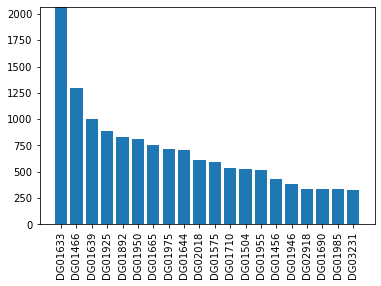

In [ ]:

def plot_top(drug_groups, num):
  # Sort the dictionary by values in descending order
  sorted_groups = sorted(drug_groups.items(), key=lambda x: x[1], reverse=True)

  # Get the keys and values from the dictionary
  keys = [x[0] for x in sorted_groups]
  values = [x[1] for x in sorted_groups]

  # Only keep the top 20 values
  keys = keys[:num]
  values = values[:num]

  # Set the x-axis labels and the y-axis range
  plt.xticks(range(len(keys)), keys, rotation=90)
  plt.ylim([0, max(values)])

  # Add a bar for each drug group, with the height of the bar
  # determined by the corresponding value in the dictionary
  plt.bar(range(len(keys)), values)

  # Show the plot
  plt.show()


plot_top(class_ct, 20)

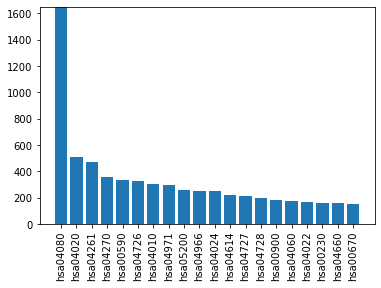

In [ ]:
plot_top(pathways_ct, 20)

In [ ]:
#plot_top(tg_ct, 20)

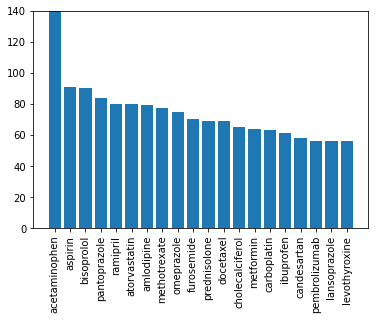

In [ ]:
plot_top(d_ct, 20)